# Prediction of in-situ local corrosion via deep learning


In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib as mpl
import tensorflow as tf
from tqdm import tqdm

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Load data with high normalization

221.89615820895517


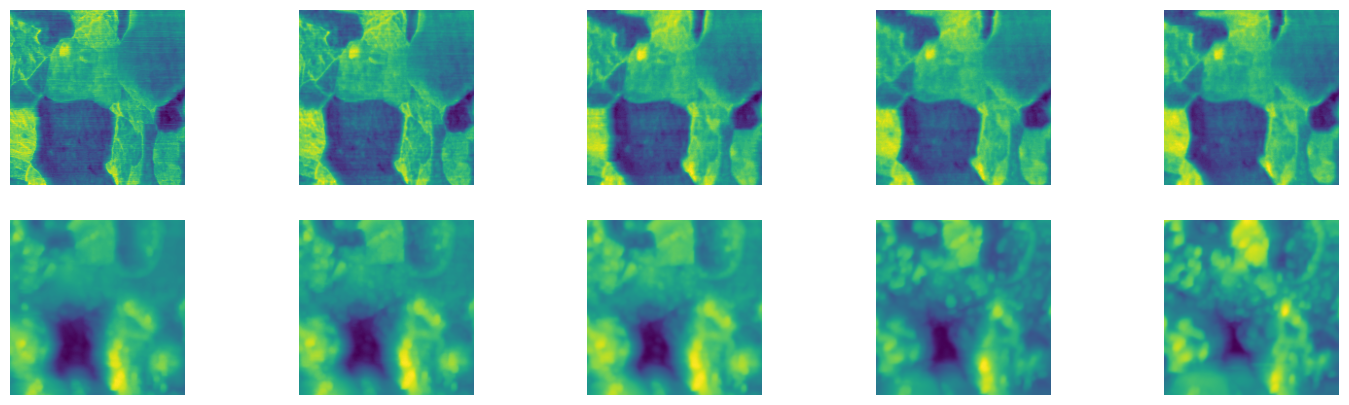

In [9]:
topo_3D = sio.loadmat(r'C:\Users\MMIL\DP_LSTM\ConvLSTM_dp_steel_data\Raw_topo_0-97min.mat')['Raw_topo3']
rows, cols, images = topo_3D.shape

absolute_maximum = np.max(topo_3D, axis = (0,1,2))
print(absolute_maximum)

topo_3D_norm = topo_3D / absolute_maximum

def seeimage(n=0):
    image = np.squeeze(np.squeeze(topo_3D_norm[:,:,n]))
    #image = np.rot90(image, k=1, axes=(0, 1))
    return image

fig2 = plt.figure(figsize=(18,5)) 
for image in range(images):
    fig2.add_subplot(2,int((images+1)/2), image+1)
    plt.imshow(seeimage(image))
    plt.axis('off')
    #plt.tight_layout();plt.clim(0,1);plt.title(str(image))
    
# fig3 = plt.figure(figsize=(18,5)) 
# for image in range(images):    
#     fig3.add_subplot(2,int((images+1)/2), image+1)
#     plt.hist(seeimage(image),range=[0,1])

## Load data from mat file for ConvLSTM model 

In [14]:
topo_3D = sio.loadmat(r'C:\Users\MMIL\DP_LSTM\ConvLSTM_dp_steel_data\Topo_55-121min_for_LSTM.mat')['Raw_topo1']
rows, cols, images = topo_3D.shape

## Height normalization 

524.5509


C:\Users\MMIL\AppData\Local\Temp\ipykernel_28008\4206724160.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout();plt.clim(0,1);plt.title(str(image))


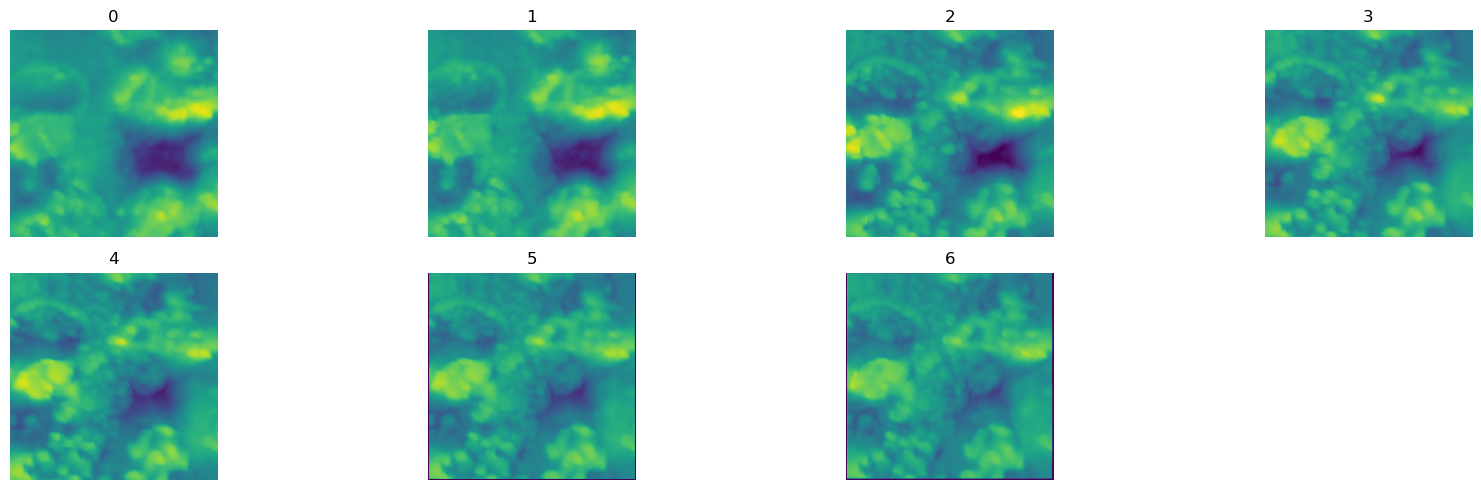

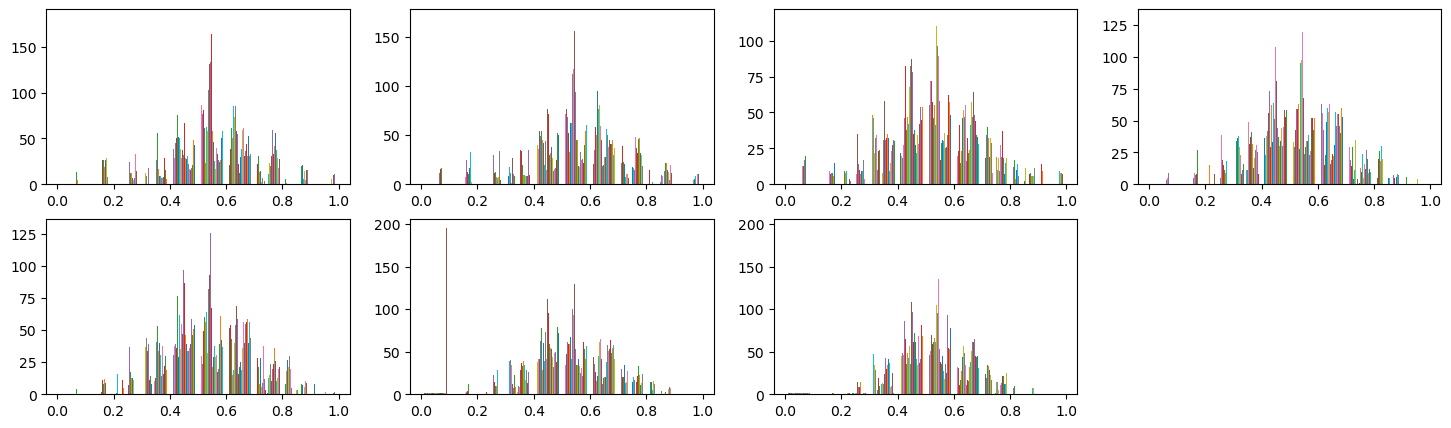

In [15]:
absolute_maximum = np.max(topo_3D, axis = (0,1,2))
print(absolute_maximum)

topo_3D_norm = topo_3D / absolute_maximum

def seeimage(n=0):
    image = np.squeeze(np.squeeze(topo_3D_norm[:,:,n]))
    image = np.rot90(image, k=1, axes=(0, 1))
    return image

fig2 = plt.figure(figsize=(18,5)) 
for image in range(images):
    fig2.add_subplot(2,int((images+1)/2), image+1);plt.imshow(seeimage(image));plt.axis('off')
    plt.tight_layout();plt.clim(0,1);plt.title(str(image))
    
fig3 = plt.figure(figsize=(18,5)) 
for image in range(images):    
    fig3.add_subplot(2,int((images+1)/2), image+1);plt.hist(seeimage(image),range=[0,1])

## Data preaparation for ConvLSTM

In [16]:
look_back = 3

topo_3D_norm_trc = np.moveaxis(topo_3D_norm,-1,0) # Re-arrange to time,rol,col
 
rows,cols,images = topo_3D_norm_trc.shape

print(rows,cols,images)

# convert an array of values into a dataset matrix

def create_dataset(topo_3D_norm, look_back):
    
    def get_xy(cn_row, cn_cols,cn_imag,inputmat,lookback):
    
        center_row, center_col, center_image = cn_row,cn_cols,cn_imag
        pulled_x = inputmat[center_image-lookback:center_image, center_row-1:center_row+2, center_col-1:center_col+2]
        pulled_y = inputmat[center_image, center_row, center_col]
                
        return pulled_x, pulled_y
    
    images,rows, cols = topo_3D_norm.shape
    
    dataX, dataY = [], []
    
    for row in range(1,rows-1,1): #range(start, stop, step)
        for col in range(1,cols-1,1):
            for i in range(look_back, images, 1):

                x_data, y_data = get_xy(row,col,i,topo_3D_norm,look_back)
                
                #print(row,col,i)
                #print(x_data.shape)
                #print(y_data)
                
                dataX.append(x_data)
                dataY.append(y_data)
    print(row, col, i)            
    return np.array(dataX), np.array(dataY)    

data_X, data_Y = create_dataset(topo_3D_norm_trc,look_back)

#########################################
# Format input axis
# we use data_format='channels_last' 
# Input shape of ConvLSTM2D: 5D tensor with shape: (samples, time, rows, cols, channels)
#####################
data_X = np.expand_dims(data_X, axis=4)
print(data_X.shape)
print(data_Y.shape)

7 196 196
194 194 6
(150544, 3, 3, 3, 1)
(150544,)


## Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(120435, 3, 3, 3, 1)
(30109, 3, 3, 3, 1)


## Creat ConvLSTM network

In [18]:
# create and fit the LSTM network

look_back = 3

input_shape =(1, look_back, 3, 3, 1)

model = Sequential()
model.add(tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(2, 2), activation='relu', 
                               input_shape=input_shape[1:], data_format='channels_last',
                               return_sequences=True))
model.add(tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(2, 2), activation='relu', 
                               input_shape=input_shape[1:], data_format='channels_last',
                               return_sequences=True))
model.add(tf.keras.layers.Flatten()) 
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

history  = model.fit(X_train, y_train, validation_data=(X_test, y_test) ,epochs=10, batch_size=200, verbose=1) #batch_size = 50, epcchs = 5

# Get training and test loss histories
training_loss = history .history ['loss']
test_loss = history .history ['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)



Epoch 1/10

603/603 [==============================] - 10s 13ms/step - loss: 0.0091 - val_loss: 0.0012
Epoch 2/10
603/603 [==============================] - 8s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/10
603/603 [==============================] - 7s 12ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/10
603/603 [==============================] - 8s 12ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/10
603/603 [==============================] - 8s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/10
603/603 [==============================] - 8s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/10
603/603 [==============================] - 8s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
603/603 [==============================] - 8s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
603/603 [==============================] - 8s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/10
941/941 [==============================] - 2s 2ms/step


## Accuracy

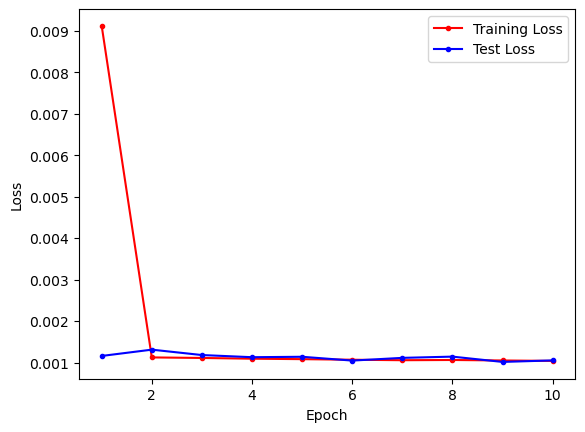

In [19]:
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r.-')
plt.plot(epoch_count, test_loss, 'b.-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Prediction

In [20]:
topo_3D_norm_trc = np.moveaxis(topo_3D_norm,-1,0) # Re-arrange to time,rol,col

def predict_image(topo_3D_norm_input, im_num,lookback):
    
    def get_x(cn_row, cn_cols,cn_imag,inputmat,lookback):
    
        center_row, center_col, center_image = cn_row,cn_cols,cn_imag
        
        pulled_x = inputmat[center_image-lookback:center_image, center_row-1:center_row+2, center_col-1:center_col+2]

        return pulled_x
    
    images,rows, cols = topo_3D_norm_input.shape
    pred_im_output = np.zeros((rows, cols))
    
    for row in tqdm(range(1,rows-1,1), desc ="predicting"): #range(start, stop, step)
        for col in range(1,cols-1,1):
            
            x_data= get_x(row,col,im_num,topo_3D_norm_input,lookback)
            x_data = np.expand_dims(x_data, axis=3)
            x_data = np.expand_dims(x_data, axis=0)
         
            #make predictions
            pixel_predicted = model.predict(x_data, verbose=0)
            pred_im_output[row,col] = pixel_predicted
            
    return  pred_im_output   

predicting: 100%|██████████| 194/194 [26:41<00:00,  8.25s/it]


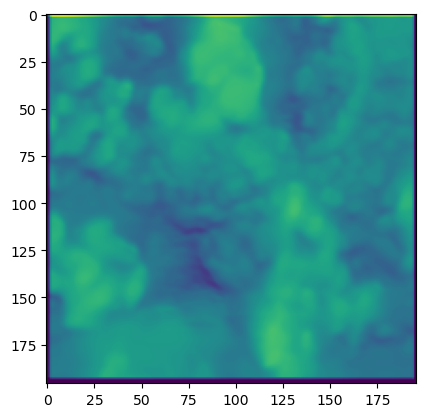

In [22]:
images,rows, cols = topo_3D_norm_trc.shape
pred_im_set_trc = np.zeros((images+2,rows, cols))

lookback = 3 ##if you use the look back 3 you can not predict 0 1 2 

pred_im_set_trc[4,:,:] = predict_image(topo_3D_norm_trc, 4, lookback)
pred_im_set_trc[5,:,:] = predict_image(topo_3D_norm_trc, 5, lookback)
pred_im_set_trc[6,:,:] = predict_image(topo_3D_norm_trc, 6, lookback)

##next step
pred_im_set_trc[7,:,:] = predict_image(pred_im_set_trc, 7, lookback)
pred_im_set_trc[8,:,:] = predict_image(pred_im_set_trc, 8, lookback)
#pred_im_set_trc[9,:,:] = predict_image(pred_im_set_trc, 9, lookback)

plt.imshow(np.squeeze(pred_im_set_trc[7,:,:]))

C:\Users\MMIL\AppData\Local\Temp\ipykernel_28008\3016328982.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout();plt.title(str(image))


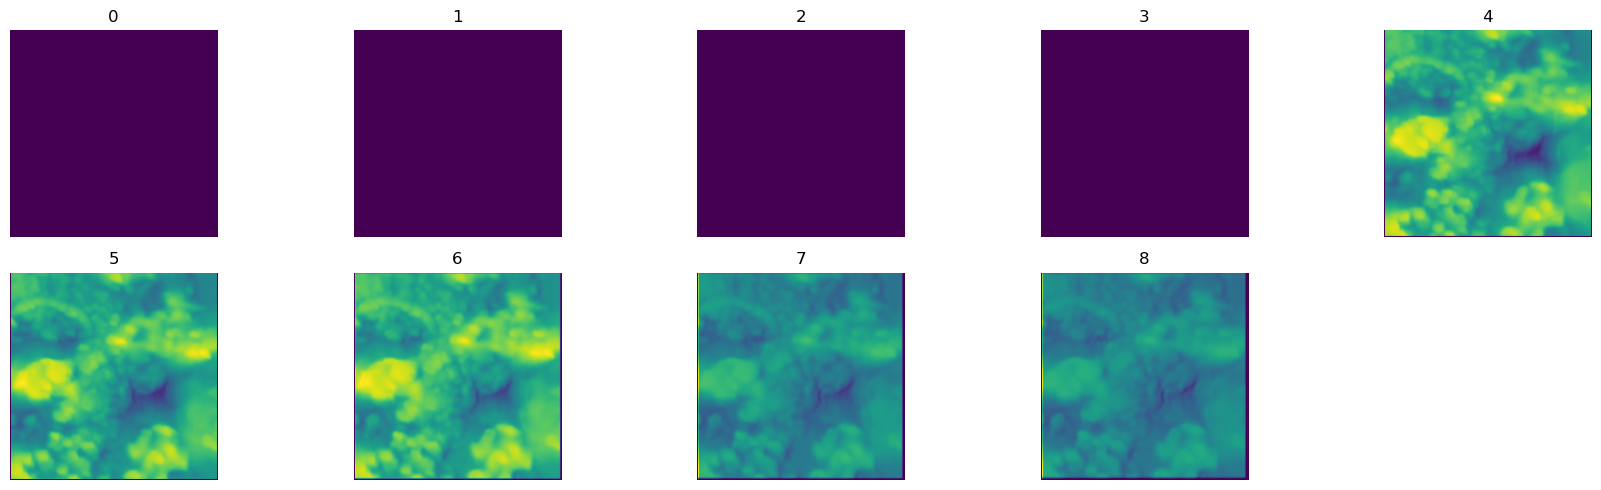

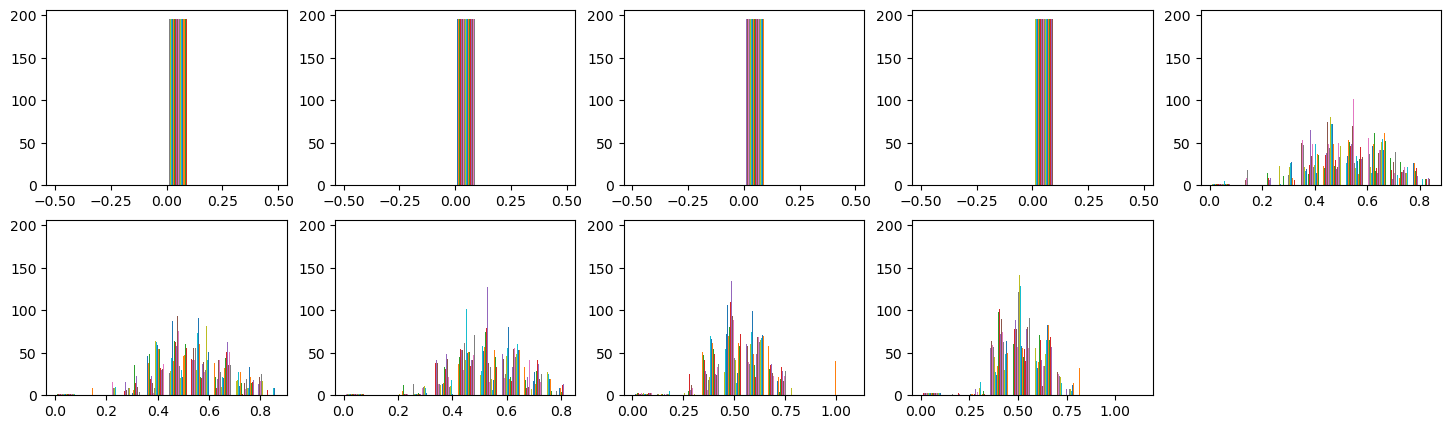

In [23]:
pred_im_set = np.moveaxis(pred_im_set_trc,0,-1)

rows,cols,images = pred_im_set.shape

pred_im_set_rot = np.zeros((rows,cols,images))

for image in range(images):
    image_ex = np.squeeze(np.squeeze(pred_im_set[:,:,image]))
    pred_im_set_rot[:,:,image] =  np.rot90(image_ex, k=1, axes=(0, 1))

def seeimage_ori(n=0):
    image = np.squeeze(np.squeeze(pred_im_set_rot[:,:,n]))

    return image

fig2 = plt.figure(figsize=(18,5)) 
for image in range(images):
    fig2.add_subplot(2,int((images+1)/2), image+1);plt.imshow(seeimage_ori(image));plt.axis('off');
    plt.tight_layout();plt.title(str(image))
    
fig3 = plt.figure(figsize=(18,5)) 
for image in range(images):    
    fig3.add_subplot(2,int((images+1)/2), image+1);plt.hist(seeimage_ori(image));    


Predict_topo = {"Predict_topo": pred_im_set[:,:,:]*absolute_maximum}

#Saving to .mat
sio.savemat(r"C:\Users\MMIL\DP_LSTM\ConvLSTM_dp_steel_data"+"\\"+"Pre_topo_v1c.mat",Predict_topo )

## Remove extra pixels before save

In [24]:
rows,cols,images = pred_im_set_rot.shape
rows_crop,cols_crop,images = rows-4,cols-4,images

pred_im_set_crop = np.zeros((rows_crop,cols_crop,images))

for ro in range(rows_crop):
    for co in range(cols_crop):
          pred_im_set_crop[ro,co] = pred_im_set_rot[ro+2,co+2] 

C:\Users\MMIL\AppData\Local\Temp\ipykernel_28008\2587378551.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout();plt.title(str(image))


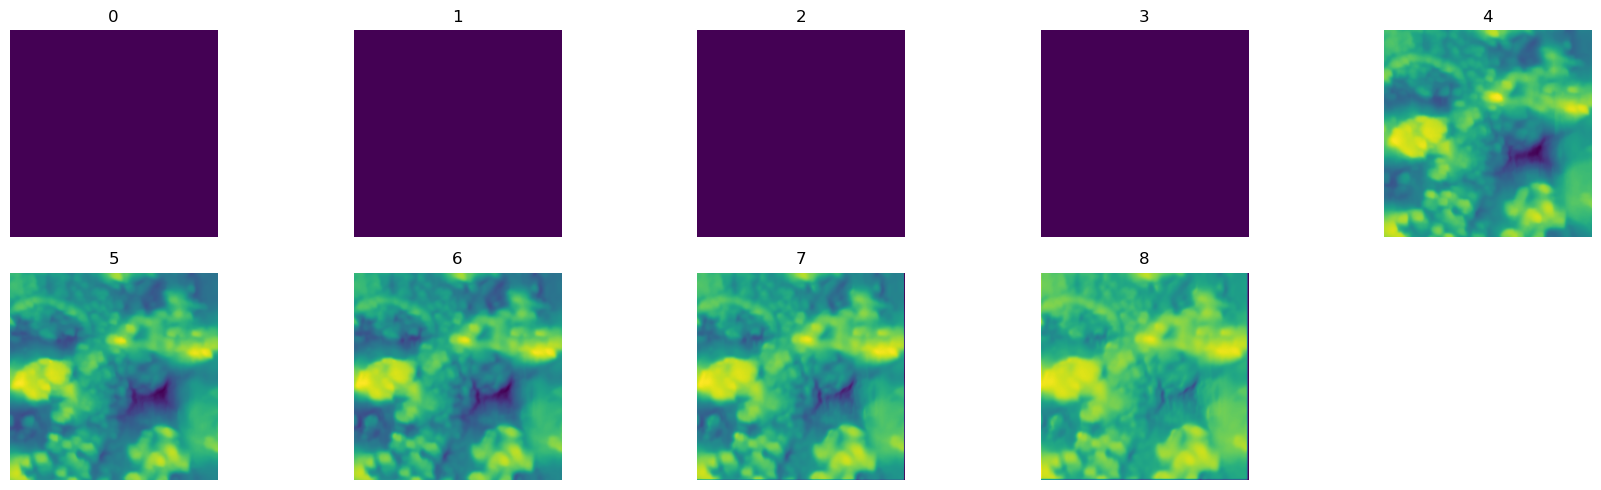

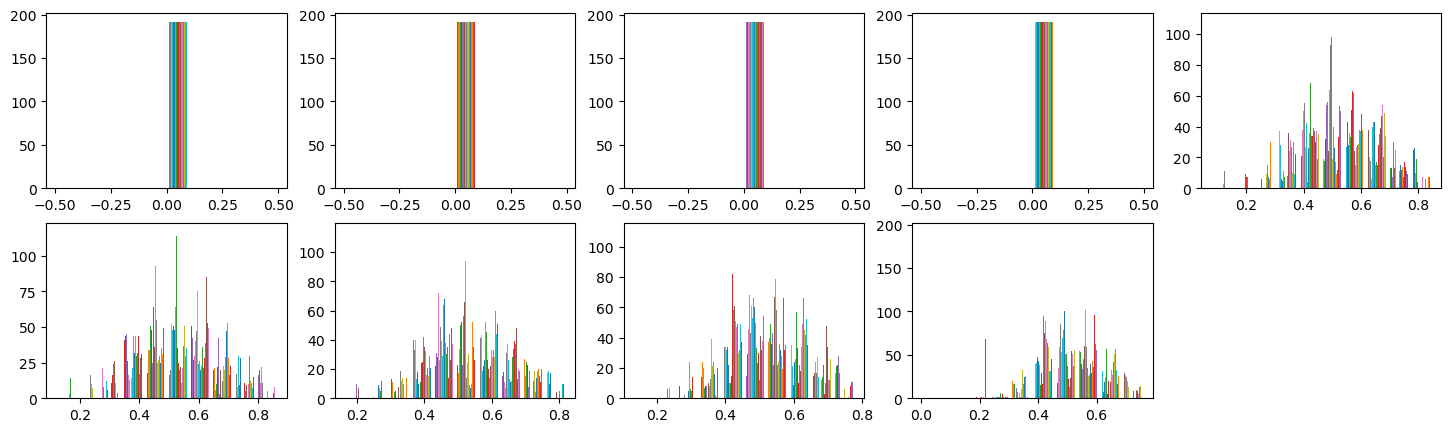

In [25]:
def seeimage_ori(n=0):
    image = np.squeeze(np.squeeze(pred_im_set_crop[:,:,n]))
    return image

fig2 = plt.figure(figsize=(18,5)) 
for image in range(images):
    fig2.add_subplot(2,int((images+1)/2), image+1);plt.imshow(seeimage_ori(image));plt.axis('off');
    plt.tight_layout();plt.title(str(image))
    
fig3 = plt.figure(figsize=(18,5)) 
for image in range(images):    
    fig3.add_subplot(2,int((images+1)/2), image+1);plt.hist(seeimage_ori(image));    

## Save file

In [26]:
topo_predby2DLSTM = {"topo_2last_predby2DLSTM": pred_im_set_crop[:,:,:]*absolute_maximum}

#Saving to .mat
sio.savemat(r"C:\Users\MMIL\DP_LSTM\ConvLSTM_dp_steel_data"+"\\"+"topo_predby2DLSTM_lookback3_v10d.mat",topo_predby2DLSTM)